In [7]:
from pyscf import scf, gto, fci
from openfermionpyscf._run_pyscf import compute_integrals, generate_molecular_hamiltonian
from openparticle import ParticleOperator, get_fock_basis, generate_matrix
import numpy as np
from functools import partial
import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..'))
import cirq
from cirq.contrib.svg import SVGCircuit
from src.lobe.system import System
from src.lobe.fermionic import fermionic_product_block_encoding, fermionic_plus_hc_block_encoding
from src.lobe.asp import get_target_state, add_prepare_circuit
from src.lobe.metrics import CircuitMetrics
from src.lobe.index import index_over_terms
from tests._utils import _validate_block_encoding
from src.lobe.lcu import LCU

def get_nonzero_terms(arr, tol=1e-10):
    """
    """
    where_nonzero = np.where(~np.isclose(arr, 0, atol=tol))
    nonzero_indices = list(zip(*where_nonzero))
    return dict(zip(nonzero_indices, arr[where_nonzero]))

In [8]:
# geom = [('N', (0, 0, 0)), ('N', (0, 0, 2))]
geom = [('Li', (0, 0, 0)), ('H', (0, 0, 1.5))]
# geom = [('H', (0, 0, 0)),
#         ('H', (0, 0, 1)),
#         ('H', (0, 0, 2)),
#         ('H', (0, 0, 3)),]

# geom = [('H', (0, 0, 0)),
#         ('H', (0, 0, 1))]

basis = 'sto-3g'

mol = gto.M(
    atom=geom,
    basis = basis,
    unit='A').build()


hf_obj = scf.RHF(mol)
hf_obj.kernel()

assert hf_obj.converged, 'calc has NOT converged. Increase number of cycles!'
print(f'n_qubits: {2*mol.nao}')



converged SCF energy = -7.86335762153512
n_qubits: 12


In [9]:
if 2*mol.nao<100:
    fci_obj = fci.FCI(hf_obj)
    fci_obj.kernel()

print(f'true ground state: {fci_obj.e_tot}')

true ground state: -7.882362286798725


In [10]:
one_electron_integrals, two_electron_integrals = compute_integrals(mol, hf_obj)

hcore = np.zeros([mol.nao*2]*2)
hcore[ ::2, ::2] = one_electron_integrals
hcore[1::2,1::2] = one_electron_integrals

eri = np.zeros([mol.nao*2]*4)
eri[ ::2, ::2, ::2, ::2] = two_electron_integrals
eri[1::2,1::2,1::2,1::2] = two_electron_integrals
eri[0::2,1::2,1::2,0::2] = two_electron_integrals
eri[1::2,0::2,0::2,1::2] = two_electron_integrals

In [11]:
from openfermion import InteractionOperator, FermionOperator

# interaction_operator = InteractionOperator(
#         constant = hf_obj.energy_nuc(), 
#         one_body_tensor = one_electron_integrals, 
#         two_body_tensor = two_electron_integrals*.5)



one_body_coefficients = get_nonzero_terms(hcore)
two_body_coefficients = get_nonzero_terms(eri)



In [12]:
fermionic_molecular_hamiltonian = FermionOperator('', hf_obj.energy_nuc())
for (p,q), coeff in one_body_coefficients.items():
        fermionic_molecular_hamiltonian += FermionOperator(f'{p}^ {q}', coeff)
for (p,q,r,s), coeff in two_body_coefficients.items():
        fermionic_molecular_hamiltonian += FermionOperator(f'{p}^ {q}^ {r} {s}', coeff*.5)
fermionic_molecular_hamiltonian

1.05835442184 [] +
-4.7492364119798 [0^ 0] +
0.8290833875826688 [0^ 0^ 0 0] +
-0.05842796239387208 [0^ 0^ 0 2] +
-0.06881783154135354 [0^ 0^ 0 4] +
0.021710561571456934 [0^ 0^ 0 10] +
-0.058427962393872046 [0^ 0^ 2 0] +
0.00734891307504637 [0^ 0^ 2 2] +
0.005771783138116815 [0^ 0^ 2 4] +
-0.004068579684213664 [0^ 0^ 2 10] +
-0.06881783154135357 [0^ 0^ 4 0] +
0.005771783138116819 [0^ 0^ 4 2] +
0.01075647667681086 [0^ 0^ 4 4] +
-0.000633516396631705 [0^ 0^ 4 10] +
0.004909613657085833 [0^ 0^ 6 6] +
0.004909613657085834 [0^ 0^ 8 8] +
0.0217105615714569 [0^ 0^ 10 0] +
-0.004068579684213659 [0^ 0^ 10 2] +
-0.0006335163966316963 [0^ 0^ 10 4] +
0.0036206208647424987 [0^ 0^ 10 10] +
0.8290833875826688 [0^ 1^ 1 0] +
-0.05842796239387208 [0^ 1^ 1 2] +
-0.06881783154135354 [0^ 1^ 1 4] +
0.021710561571456934 [0^ 1^ 1 10] +
-0.058427962393872046 [0^ 1^ 3 0] +
0.00734891307504637 [0^ 1^ 3 2] +
0.005771783138116815 [0^ 1^ 3 4] +
-0.004068579684213664 [0^ 1^ 3 10] +
-0.06881783154135357 [0^ 1^ 5 0] +


In [13]:
from openparticle import ParticleOperator
fermionic_molecular_hamiltonian = ParticleOperator('', hf_obj.energy_nuc())

for (p,q), coeff in one_body_coefficients.items():
        fermionic_molecular_hamiltonian += ParticleOperator(f'b{p}^ b{q}', coeff)
for (p,q,r,s), coeff in two_body_coefficients.items():
        if p==q or r==s:
                pass
        else:
                if len(set([p,q,r,s])) == 4:
                        fermionic_molecular_hamiltonian += int(r == q) * ParticleOperator(f'b{p}^ b{s}', coeff*.5) - ParticleOperator(f'b{p}^ b{r} b{q}^ b{s}', coeff*.5)
                elif len(set([p,q,r,s])) == 3:
                        if p == r:
                                fermionic_molecular_hamiltonian +=  ParticleOperator(f'b{p}^ b{r} b{q}^ b{s}', -coeff*.5)
                        elif p == s:
                                fermionic_molecular_hamiltonian +=  ParticleOperator(f'b{p}^ b{s} b{q}^ b{r} ', coeff*.5)
                        elif q == r:
                                fermionic_molecular_hamiltonian +=  ParticleOperator(f'b{p}^ b{q}^ b{r} b{s} ', coeff*.5)
                        elif q == s:
                                fermionic_molecular_hamiltonian +=  ParticleOperator(f'b{p}^ b{q}^ b{s} b{r}  ', -coeff*.5)
                elif len(set([p,q,r,s])) == 2:
                        if p == s:
                                # implies q ==r
                                fermionic_molecular_hamiltonian +=  ParticleOperator(f'b{p}^ b{s} b{q}^ b{r}', coeff*.5)
                        elif p==r:
                                # implies q==s:
                                fermionic_molecular_hamiltonian +=  ParticleOperator(f'b{p}^ b{r} b{q}^ b{s} ', -coeff*.5)


        

In [552]:
from openparticle import ParticleOperator
fermionic_molecular_hamiltonian = ParticleOperator('', hf_obj.energy_nuc())

for (p,q), coeff in one_body_coefficients.items():
        fermionic_molecular_hamiltonian += ParticleOperator(f'b{p}^ b{q}', coeff)
for (p,q,r,s), coeff in two_body_coefficients.items():
        #Two-body terms bp^ bq^ br bs = delta(r, q) bp^ bs - bp^ br bq^ bs
        # if p == r == q == s:
        #         pass
        # elif p == q == r:
        #         # fermionic_molecular_hamiltonian += int(r == q) * ParticleOperator(f'b{p}^ b{s}', coeff*.5) - ParticleOperator(f'b{s}', coeff*.5)
        #         pass
        # elif r == q == s:
        #         pass
        # elif p == q or r == s:
        #         pass
        # elif p == s:
        #         if s != q != r:
        #                 fermionic_molecular_hamiltonian += int(r == q) * ParticleOperator(f'b{p}^ b{s}', coeff*.5) - ParticleOperator(f'b{p}^ b{s} b{r} b{q}^', coeff*.5)
        #         elif r == q:
        #                 fermionic_molecular_hamiltonian += int(r == q) * ParticleOperator(f'b{p}^ b{s}', coeff*.5) - ParticleOperator(f'b{p}^ b{s} b{r} b{q}^', coeff*.5)
        #         # #bp^ bq^ br bp
        #         # #Scenario where indices aren't grouped as pairs
        #         # fermionic_molecular_hamiltonian += ParticleOperator(f'b{p}^ b{p} b{q}^ b{r}')
        # elif q == r and p != s:
        #         #bp^ bq^ bq bs
        #         fermionic_molecular_hamiltonian += ParticleOperator(f'b{p}^ b{q}^ b{q} b{s}')
        # else:
        #         fermionic_molecular_hamiltonian += int(r == q) * ParticleOperator(f'b{p}^ b{s}', coeff*.5) - ParticleOperator(f'b{p}^ b{r} b{q}^ b{s}', coeff*.5)

SyntaxError: incomplete input (2829065056.py, line 29)

In [14]:
fermionic_molecular_hamiltonian

1.05835442184 * 
-4.7492364119798 * b0^ b0
0.10960153743201594 * b0^ b2
0.16815660166252872 * b0^ b4
-0.025658829875603077 * b0^ b10
-4.7492364119798 * b1^ b1
0.10960153743201594 * b1^ b3
0.16815660166252872 * b1^ b5
-0.025658829875603077 * b1^ b11
0.10960153743201584 * b2^ b0
-1.53207872356986 * b2^ b2
0.035618490618169296 * b2^ b4
-0.08312192374154082 * b2^ b10
0.10960153743201584 * b3^ b1
-1.53207872356986 * b3^ b3
0.035618490618169296 * b3^ b5
-0.08312192374154082 * b3^ b11
0.16815660166252852 * b4^ b0
0.03561849061816917 * b4^ b2
-1.1325306577734406 * b4^ b4
0.032303096756846866 * b4^ b10
0.16815660166252852 * b5^ b1
0.03561849061816917 * b5^ b3
-1.1325306577734406 * b5^ b5
0.032303096756846866 * b5^ b11
-1.145344338651623 * b6^ b6
-1.145344338651623 * b7^ b7
-1.1453443386516236 * b8^ b8
-1.1453443386516236 * b9^ b9
-0.02565882987560297 * b10^ b0
-0.08312192374154066 * b10^ b2
0.03230309675684678 * b10^ b4
-0.9335824975776704 * b10^ b10
-0.02565882987560297 * b11^ b1
-0.0831219237

In [15]:
const = fermionic_molecular_hamiltonian.op_dict.pop(())
fermionic_molecular_hamiltonian.remove_identity()

0

In [16]:
# basis_fermion = get_fock_basis(fermionic_molecular_hamiltonian)
# matrix = generate_matrix(fermionic_molecular_hamiltonian, basis_fermion)
# vals  = np.linalg.eigvalsh(matrix.real)

from scipy import sparse
vals, vecs = sparse.linalg.eigsh(fermionic_molecular_hamiltonian.to_paulis(fermionic_molecular_hamiltonian.max_fermionic_mode).to_sparse_matrix.real)

In [18]:
E0_openparticle = min(vals) + const
E0_openparticle

-7.882362286798695

In [19]:
fci_obj.e_tot - E0_openparticle

-3.019806626980426e-14

In [20]:
def get_fermionic_modes(operator):
    cleaned_modes = []
    cleaned_types = []

    assert len(operator.to_list()) == 1

    modes = list(tuple(t[1] for t in list(operator.op_dict.keys())[0]))
    types = list(tuple(t[-1] for t in list(operator.op_dict.keys())[0]))
    # print("---", operator, "---")
    # print("before cleaning", modes, types)

    i = 0
    while i < len(modes):
        if i != len(modes) - 1 and modes[i] == modes[i + 1] and types[i] == 1 and types[i + 1] == 0:
            cleaned_modes.append(modes[i])
            cleaned_types.append(2)
            i += 2
            continue
        else:
            cleaned_modes.append(modes[i])
            cleaned_types.append(types[i])
            i += 1
    
    # print("after cleaning", cleaned_modes, cleaned_types)
    return tuple(cleaned_modes[::-1]), tuple(cleaned_types[::-1])

In [21]:
grouped_terms = fermionic_molecular_hamiltonian.to_list()

number_of_block_encoding_ancillae = 1
index_register = [
    cirq.LineQubit(-i - 2) for i in range(int(np.ceil(np.log2(len(grouped_terms)))))
]
block_encoding_ancillae = [
    cirq.LineQubit(-100 - i - len(index_register))
    for i in range(number_of_block_encoding_ancillae)
]
print(block_encoding_ancillae)
number_of_block_encoding_ancillae = len(block_encoding_ancillae)
ctrls = ([cirq.LineQubit(0)], [1])
clean_ancillae = [cirq.LineQubit(i + 100) for i in range(100)]
system = System(
    fermionic_molecular_hamiltonian.max_fermionic_mode + 1,
    0,
    1000,
    True,
    False,
    False,
)

block_encoding_functions = []
rescaling_factors = []
for term in grouped_terms:
    plus_hc = False
    if len(term) == 2:
        plus_hc = True
        term = term.to_list()[0]
    active_modes, operator_types = get_fermionic_modes(term)
    print(term, active_modes, operator_types)
    if not plus_hc:
        
        block_encoding_functions.append(
            partial(
                fermionic_product_block_encoding,
                system=system,
                block_encoding_ancilla=block_encoding_ancillae[0],
                active_indices=active_modes,
                operator_types = operator_types,
                sign = np.sign(term.coeff),
                clean_ancillae=clean_ancillae[1:],
            )
        )
        rescaling_factors.append(1)
    else:
        block_encoding_functions.append(
            partial(
                fermionic_plus_hc_block_encoding,
                system=system,
                block_encoding_ancilla=block_encoding_ancillae,
                active_indices=active_modes,
                operator_types = operator_types,
                sign = np.sign(term.coeff),
                clean_ancillae=clean_ancillae[1:],
            )
        )

rescaled_coefficients = []
for term, rescaling_factor in zip(grouped_terms, rescaling_factors):
    rescaled_coefficients.append(
        term.coeffs[0] * rescaling_factor / max(rescaling_factors)
    )

target_state = get_target_state(rescaled_coefficients)
gates = []
metrics = CircuitMetrics()

gates.append(cirq.X.on(ctrls[0][0]))

_gates, _metrics = add_prepare_circuit(
    index_register, target_state, clean_ancillae=clean_ancillae
)
print("Metrics from add_prepare_circuit: \n")
_metrics.display_metrics()
gates += _gates
metrics += _metrics

_gates, _metrics = index_over_terms(
    index_register, block_encoding_functions, clean_ancillae, ctrls=ctrls
)
print("Metrics from index_over_terms: \n")
_metrics.display_metrics() #Print metrics
gates += _gates
metrics += _metrics

_gates, _metrics = add_prepare_circuit(
    index_register, target_state, dagger=True, clean_ancillae=clean_ancillae
)
print("Metrics from add_prepare_circuit: \n")
_metrics.display_metrics()
gates += _gates
metrics += _metrics

gates.append(cirq.X.on(ctrls[0][0]))

overall_rescaling_factor = sum(
    [
        term.coeffs[0] * rescaling_factor
        for term, rescaling_factor in zip(grouped_terms, rescaling_factors)
    ]
)

print("Total metrics of the block encoding: \n")
metrics.display_metrics()


[cirq.LineQubit(-111)]
-4.7492364119798 * b0^ b0
 (0,) (2,)
0.10960153743201594 * b0^ b2
 (2, 0) (0, 1)
0.16815660166252872 * b0^ b4
 (4, 0) (0, 1)
-0.025658829875603077 * b0^ b10
 (10, 0) (0, 1)
-4.7492364119798 * b1^ b1
 (1,) (2,)
0.10960153743201594 * b1^ b3
 (3, 1) (0, 1)
0.16815660166252872 * b1^ b5
 (5, 1) (0, 1)
-0.025658829875603077 * b1^ b11
 (11, 1) (0, 1)
0.10960153743201584 * b2^ b0
 (0, 2) (0, 1)
-1.53207872356986 * b2^ b2
 (2,) (2,)
0.035618490618169296 * b2^ b4
 (4, 2) (0, 1)
-0.08312192374154082 * b2^ b10
 (10, 2) (0, 1)
0.10960153743201584 * b3^ b1
 (1, 3) (0, 1)
-1.53207872356986 * b3^ b3
 (3,) (2,)
0.035618490618169296 * b3^ b5
 (5, 3) (0, 1)
-0.08312192374154082 * b3^ b11
 (11, 3) (0, 1)
0.16815660166252852 * b4^ b0
 (0, 4) (0, 1)
0.03561849061816917 * b4^ b2
 (2, 4) (0, 1)
-1.1325306577734406 * b4^ b4
 (4,) (2,)
0.032303096756846866 * b4^ b10
 (10, 4) (0, 1)
0.16815660166252852 * b5^ b1
 (1, 5) (0, 1)
0.03561849061816917 * b5^ b3
 (3, 5) (0, 1)
-1.1325306577734406 

In [469]:
# check_unitary(operator, cirq.Circuit(gates), system, overall_rescaling_factor)
_validate_block_encoding(cirq.Circuit(gates), system, overall_rescaling_factor, fermionic_molecular_hamiltonian, 1 + len(index_register), 1)

Testing singular quantum state for circuit with 13 qubits


In [22]:
len(fermionic_molecular_hamiltonian)

1248

In [23]:
len(fermionic_molecular_hamiltonian.group())

368

In [24]:
def get_active_fermionic_modes(operator):
    active_modes = []
    for term in operator.to_list():
        for op in term.split():
            index = str(op)[str(op).index("b")+1:]
            if "^" in index:
                index = index[:-2]
            index = int(index)
            active_modes.append(index)
                
    return active_modes

def lobe_order_individual_op(op):
    n_modes = len(op.to_list()[0].split())
    assert n_modes in [2,4], 'not correct form. Either too many modes OR not a single operator'

    if n_modes==2:
            return op
    else:
        terms = get_active_fermionic_modes(op)
        if len(terms) == 4:
                p,q,r,s = terms
        
                if len(set([p,q,r,s])) == 4:
                        new_op = op
                elif len(set([p,q,r,s])) == 3:
                        if p == r:
                                new_op =  ParticleOperator(f'b{p}^ b{r} b{q}^ b{s}  ', -op.coeff)
                        elif p == s:
                                new_op =  ParticleOperator(f'b{p}^ b{s} b{q}^ b{r}', op.coeff)
                        elif q == r:
                                new_op = op
                                # new_op =  ParticleOperator(f'b{p}^ b{q}^ b{r} b{s}  ', op.coeff)
                        elif q == s:
                                new_op =  ParticleOperator(f'b{p}^ b{q}^ b{s} b{r}', -op.coeff)
                elif len(set([p,q,r,s])) == 2:
                        if p == s:
                                # implies q ==r
                                new_op =  ParticleOperator(f'b{p}^ b{s} b{q}^ b{r}', op.coeff)
                        elif p==r:
                                # implies q==s:
                                new_op =  ParticleOperator(f'b{p}^  b{r} b{q}^ b{s}  ', -op.coeff)

                return new_op
        elif len(terms) == 8:
                op1, op1_dag = op.to_list()
                p,q,r,s = get_active_fermionic_modes(op1)

                if len(set([p,q,r,s])) == 4:
                        new_op  = op1
                elif len(set([p,q,r,s])) == 3:
                        if p == r:
                                new_op =  ParticleOperator(f'b{p}^ b{r} b{q}^ b{s}  ', -op1.coeff)
                        elif p == s:
                                new_op =  ParticleOperator(f'b{p}^ b{s} b{q}^ b{r}', op1.coeff)
                        elif q == r:
                                new_op = op1
                                # new_op =  ParticleOperator(f'b{p}^ b{q}^ b{r} b{s}  ', op.coeff)
                        elif q == s:
                                new_op =  ParticleOperator(f'b{p}^ b{q}^ b{s} b{r}', -op1.coeff)
                elif len(set([p,q,r,s])) == 2:
                        if p == s:
                                # implies q ==r
                                new_op =  ParticleOperator(f'b{p}^ b{s} b{q}^ b{r}', op1.coeff)
                        elif p==r:
                                # implies q==s:
                                new_op =  ParticleOperator(f'b{p}^  b{r} b{q}^ b{s}  ', -op1.coeff)

                p,q,r,s = get_active_fermionic_modes(op1_dag)
                if len(set([p,q,r,s])) == 4:
                        new_op2 = op1_dag
                elif len(set([p,q,r,s])) == 3:
                        if p == r:
                                new_op2 =  ParticleOperator(f'b{p}^ b{r} b{q}^ b{s}  ', -op1_dag.coeff)
                        elif p == s:
                                new_op2 =  ParticleOperator(f'b{p}^ b{s} b{q}^ b{r}', op1_dag.coeff)
                        elif q == r:
                                new_op2 = op1_dag
                        elif q == s:
                                new_op2 =  ParticleOperator(f'b{p}^ b{q}^ b{s} b{r}', -op1_dag.coeff)
                elif len(set([p,q,r,s])) == 2:
                        if p == s:
                                # implies q ==r
                                new_op2 =  ParticleOperator(f'b{p}^ b{s} b{q}^ b{r}', op1_dag.coeff)
                        elif p==r:
                                # implies q==s:
                                new_op2 =  ParticleOperator(f'b{p}^ b{r} b{q}^ b{s}  ', -op.coeff)

                return new_op + new_op2

In [45]:
grouped = fermionic_molecular_hamiltonian.group()

new_group = []
new_operator = ParticleOperator("", 0)
for mini in grouped:
    new_group.append(lobe_order_individual_op(mini))

In [640]:
# op = ParticleOperator("b0^ b1 b3 b2") + ParticleOperator("b2^ b3^ b1^ b0")
# (op.group()[0] - op).normal_order().order_indices()


op = ParticleOperator("b1^ b1 b0^ b0") + ParticleOperator("b0^ b0 b1^ b1")
print((op.group()[0] - op).normal_order().order_indices())
print((op.group()[0] - op).order_indices())

# (op.group()[0] - op).order_indices().normal_order()

4.0 * b1^ b0^ b1 b0

0


In [655]:
op.normal_order().order_indices() + op.group()[0]

0

In [665]:
print(op.group()[0] - op)
print('should be equiv')
print()
print((op.group()[0] - op).normal_order())

-1.0 * b1^ b1 b0^ b0
-1.0 * b0^ b0 b1^ b1
2.0 * b1^ b0^ b1 b0

should be equiv

3.0 * b1^ b0^ b1 b0
1.0 * b0^ b1^ b0 b1



2.0 * b1^ b0^ b1 b0

In [1]:
from openparticle import ParticleOperator

In [58]:
## this is wrong:
op = ParticleOperator("b1^ b1 b0^ b0") + ParticleOperator("b0^ b0 b1^ b1")

print(((op - op.order_indices()).order_indices()).op_dict)
# print('should equal')
# print(op.order_indices())
# print('but does not :(')

### what it should do!

# 1.0 * b1^ b1 b0^ b0
# 1.0 * b0^ b0 b1^ b1

# -->
# 1.0 * b0^ b0 b1^ b1
# 1.0 * b0^ b0 b1^ b1
# ==
# 2.0 * b0^ b0 b1^ b1
# --> normal order
# -2.0 * b1^ b0^ b1 b0 

# this does NOT EQUAL:
# 2.0 * b1^ b0^ b1 b0

### SIGN DIFFERS!!!!


### TODO:
## 1. NORMAL ORDER
## 2. order the daggers and non-daggers then :) (Fermions track sign... Bosons who gives a shit :) no sign!)

{}


In [61]:
op = ParticleOperator("b1^ b2^") + ParticleOperator("b2^ b1^")
type(op.order_indices())

openparticle.src.ParticleOperator

In [668]:
op = ParticleOperator("b1^ b1 b0^ b0") + ParticleOperator("b0^ b0 b1^ b1")
print(op.group()[0])
print()
print(op)

### SIGN WRONG IN .group!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
(op.group()[0] + op).normal_order()

2.0 * b1^ b0^ b1 b0


1.0 * b1^ b1 b0^ b0
1.0 * b0^ b0 b1^ b1



1.0 * b1^ b0^ b1 b0
-1.0 * b0^ b1^ b0 b1

In [661]:
(op.group()[0] - op).normal_order()

3.0 * b1^ b0^ b1 b0
1.0 * b0^ b1^ b0 b1

In [658]:
op.normal_order()

-1.0 * b1^ b0^ b1 b0
-1.0 * b0^ b1^ b0 b1

In [654]:
op.order_indices()

2.0 * b1^ b0^ b1 b0

0

In [647]:
op.group()[0]

2.0 * b1^ b0^ b1 b0

In [643]:
op.order_indices()

2.0 * b1^ b0^ b1 b0

In [646]:
(op.order_indices() - op.group()[0].order_indices())#.order_indices()

0

In [639]:
(op.group()[0] - op)

-1.0 * b1^ b1 b0^ b0
-1.0 * b0^ b0 b1^ b1
2.0 * b1^ b0^ b1 b0

In [ ]:
2.0 * b1^ b0^ b1 b0
2.0 * b1^ b0^ b1 b0

In [638]:
(op.group()[0] - op).normal_order()

3.0 * b1^ b0^ b1 b0
1.0 * b0^ b1^ b0 b1

In [27]:
## check they are the same!

g = ParticleOperator("")
for op in grouped:
    g+=op
g.op_dict.pop(())
# (g - new_operator).normal_order()

out = g.to_paulis(g.max_fermionic_mode) - new_operator.to_paulis(new_operator.max_fermionic_mode)
out.n_terms

0

In [28]:
(g - fermionic_molecular_hamiltonian).order_indices()

0

In [29]:
len(grouped), len(fermionic_molecular_hamiltonian)

(368, 1248)

In [32]:
grouped = fermionic_molecular_hamiltonian.group()
g = ParticleOperator("",0)
for op in grouped:
    g+=op
# g.op_dict.pop(())

(g.to_paulis(g.max_fermionic_mode) - fermionic_molecular_hamiltonian.to_paulis(fermionic_molecular_hamiltonian.max_fermionic_mode)).coeff_vec

array([3.55271368e-15+0.j])

In [35]:
(new_operator.to_paulis(new_operator.max_fermionic_mode) - fermionic_molecular_hamiltonian.to_paulis(fermionic_molecular_hamiltonian.max_fermionic_mode)).coeff_vec

array([3.55271368e-15+0.j])

In [33]:
len(new_operator), len(grouped)

(630, 368)

In [34]:
len(fermionic_molecular_hamiltonian)

1248

In [36]:
lcu = LCU(fermionic_molecular_hamiltonian, None)
lcu.paulis.n_terms - 1 #neg 1 for identity!

630

 10.952+0.000j IIIIIIIIIIII +
-2.727+0.000j IIIIIIIIIIIZ +
-0.040+0.000j IIIIIIIIIXZX +
-0.040+0.000j IIIIIIIIIYZY +
-0.058+0.000j IIIIIIIXZZZX +
-0.058+0.000j IIIIIIIYZZZY +
 0.013+0.000j IXZZZZZZZZZX +
 0.013+0.000j IYZZZZZZZZZY +
-2.727+0.000j IIIIIIIIIIZI +
-0.040+0.000j IIIIIIIIXZXI +
-0.040+0.000j IIIIIIIIYZYI +
-0.058+0.000j IIIIIIXZZZXI +
-0.058+0.000j IIIIIIYZZZYI +
 0.013+0.000j XZZZZZZZZZXI +
 0.013+0.000j YZZZZZZZZZYI +
-1.762+0.000j IIIIIIIIIZII +
-0.026+0.000j IIIIIIIXZXII +
-0.026+0.000j IIIIIIIYZYII +
 0.048+0.000j IXZZZZZZZXII +
 0.048+0.000j IYZZZZZZZYII +
-1.762+0.000j IIIIIIIIZIII +
-0.026+0.000j IIIIIIXZXIII +
-0.026+0.000j IIIIIIYZYIII +
 0.048+0.000j XZZZZZZZXIII +
 0.048+0.000j YZZZZZZZYIII +
-1.527+0.000j IIIIIIIZIIII +
-0.002+0.000j IXZZZZZXIIII +
-0.002+0.000j IYZZZZZYIIII +
-1.527+0.000j IIIIIIZIIIII +
-0.002+0.000j XZZZZZXIIIII +
-0.002+0.000j YZZZZZYIIIII +
-1.603+0.000j IIIIIZIIIIII +
-1.603+0.000j IIIIZIIIIIII +
-1.603+0.000j IIIZIIIIIIII +
-1.603+0.000j

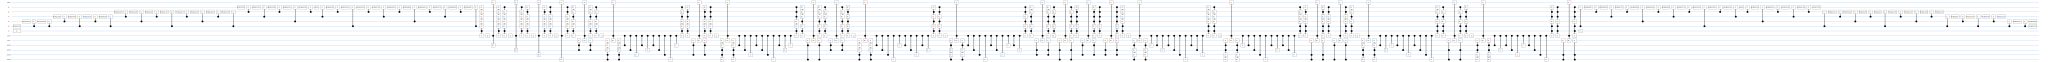

In [388]:
SVGCircuit(cirq.Circuit(gates))

In [451]:
lcu = LCU(fermionic_molecular_hamiltonian, None)
lcu.paulis.n_terms

631

In [596]:
carter = fermionic_molecular_hamiltonian.group()
carter_op= ParticleOperator("")
for op in carter:
    carter_op+=op

carter_op.op_dict.pop(())
carter_H = carter_op.to_paulis(carter_op.max_fermionic_mode)

In [597]:
# fermionic_molecular_hamiltonian.op_dict.pop(())
full_H = fermionic_molecular_hamiltonian.to_paulis(carter_op.max_fermionic_mode)

In [39]:
grouped = fermionic_molecular_hamiltonian.group()

new_operator = ParticleOperator("", 0)
for mini in grouped:
    new_operator+=lobe_order_individual_op(mini)

new_H = new_operator.to_paulis(new_operator.max_fermionic_mode)

In [42]:
len(new_operator), new_H.n_terms-1, len(grouped)

(630, 630, 368)

In [603]:
carter_H - new_H

 10.952+0.000j IIIIIIIIIIII +
-2.727+0.000j IIIIIIIIIIIZ +
-0.040+0.000j IIIIIIIIIXZX +
-0.040+0.000j IIIIIIIIIYZY +
-0.058+0.000j IIIIIIIXZZZX +
-0.058+0.000j IIIIIIIYZZZY +
 0.013+0.000j IXZZZZZZZZZX +
 0.013+0.000j IYZZZZZZZZZY +
-2.727+0.000j IIIIIIIIIIZI +
-0.040+0.000j IIIIIIIIXZXI +
-0.040+0.000j IIIIIIIIYZYI +
-0.058+0.000j IIIIIIXZZZXI +
-0.058+0.000j IIIIIIYZZZYI +
 0.013+0.000j XZZZZZZZZZXI +
 0.013+0.000j YZZZZZZZZZYI +
-1.762+0.000j IIIIIIIIIZII +
-0.026+0.000j IIIIIIIXZXII +
-0.026+0.000j IIIIIIIYZYII +
 0.048+0.000j IXZZZZZZZXII +
 0.048+0.000j IYZZZZZZZYII +
-1.762+0.000j IIIIIIIIZIII +
-0.026+0.000j IIIIIIXZXIII +
-0.026+0.000j IIIIIIYZYIII +
 0.048+0.000j XZZZZZZZXIII +
 0.048+0.000j YZZZZZZZYIII +
-1.527+0.000j IIIIIIIZIIII +
-0.002+0.000j IXZZZZZXIIII +
-0.002+0.000j IYZZZZZYIIII +
-1.527+0.000j IIIIIIZIIIII +
-0.002+0.000j XZZZZZXIIIII +
-0.002+0.000j YZZZZZYIIIII +
-1.603+0.000j IIIIIZIIIIII +
-1.603+0.000j IIIIZIIIIIII +
-1.603+0.000j IIIZIIIIIIII +
-1.603+0.000j

In [602]:
full_H - new_H

 10.952+0.000j IIIIIIIIIIII +
-2.727+0.000j IIIIIIIIIIIZ +
-0.040+0.000j IIIIIIIIIXZX +
-0.040+0.000j IIIIIIIIIYZY +
-0.058+0.000j IIIIIIIXZZZX +
-0.058+0.000j IIIIIIIYZZZY +
 0.013+0.000j IXZZZZZZZZZX +
 0.013+0.000j IYZZZZZZZZZY +
-2.727+0.000j IIIIIIIIIIZI +
-0.040+0.000j IIIIIIIIXZXI +
-0.040+0.000j IIIIIIIIYZYI +
-0.058+0.000j IIIIIIXZZZXI +
-0.058+0.000j IIIIIIYZZZYI +
 0.013+0.000j XZZZZZZZZZXI +
 0.013+0.000j YZZZZZZZZZYI +
-1.762+0.000j IIIIIIIIIZII +
-0.026+0.000j IIIIIIIXZXII +
-0.026+0.000j IIIIIIIYZYII +
 0.048+0.000j IXZZZZZZZXII +
 0.048+0.000j IYZZZZZZZYII +
-1.762+0.000j IIIIIIIIZIII +
-0.026+0.000j IIIIIIXZXIII +
-0.026+0.000j IIIIIIYZYIII +
 0.048+0.000j XZZZZZZZXIII +
 0.048+0.000j YZZZZZZZYIII +
-1.527+0.000j IIIIIIIZIIII +
-0.002+0.000j IXZZZZZXIIII +
-0.002+0.000j IYZZZZZYIIII +
-1.527+0.000j IIIIIIZIIIII +
-0.002+0.000j XZZZZZXIIIII +
-0.002+0.000j YZZZZZYIIIII +
-1.603+0.000j IIIIIZIIIIII +
-1.603+0.000j IIIIZIIIIIII +
-1.603+0.000j IIIZIIIIIIII +
-1.603+0.000j

In [50]:
# grouped_terms = new_operator.to_list()
# grouped_terms = grouped
grouped_terms = new_group

number_of_block_encoding_ancillae = 1
index_register = [
    cirq.LineQubit(-i - 2) for i in range(int(np.ceil(np.log2(len(grouped_terms)))))
]
block_encoding_ancillae = [
    cirq.LineQubit(-100 - i - len(index_register))
    for i in range(number_of_block_encoding_ancillae)
]
print(block_encoding_ancillae)
number_of_block_encoding_ancillae = len(block_encoding_ancillae)
ctrls = ([cirq.LineQubit(0)], [1])
clean_ancillae = [cirq.LineQubit(i + 100) for i in range(100)]
system = System(
    fermionic_molecular_hamiltonian.max_fermionic_mode + 1,
    0,
    1000,
    True,
    False,
    False,
)

block_encoding_functions = []
rescaling_factors = []
for term in grouped_terms:
    plus_hc = False
    if len(term) == 2:
        plus_hc = True
        term = term.to_list()[0]
    active_modes, operator_types = get_fermionic_modes(term)
    print(term, active_modes, operator_types)
    if not plus_hc:
        
        block_encoding_functions.append(
            partial(
                fermionic_product_block_encoding,
                system=system,
                block_encoding_ancilla=block_encoding_ancillae[0],
                active_indices=active_modes,
                operator_types = operator_types,
                sign = np.sign(term.coeff),
                clean_ancillae=clean_ancillae[1:],
            )
        )
        rescaling_factors.append(1)
    else:
        block_encoding_functions.append(
            partial(
                fermionic_plus_hc_block_encoding,
                system=system,
                block_encoding_ancilla=block_encoding_ancillae[0],
                active_indices=active_modes,
                operator_types = operator_types,
                sign = np.sign(term.coeff),
                clean_ancillae=clean_ancillae[1:],
            )
        )
        rescaling_factors.append(2)

rescaled_coefficients = []
for term, rescaling_factor in zip(grouped_terms, rescaling_factors):
    rescaled_coefficients.append(
        term.coeffs[0] * rescaling_factor / max(rescaling_factors)
    )

target_state = get_target_state(rescaled_coefficients)
gates = []
metrics = CircuitMetrics()

gates.append(cirq.X.on(ctrls[0][0]))

_gates, _metrics = add_prepare_circuit(
    index_register, target_state, clean_ancillae=clean_ancillae
)
print("Metrics from add_prepare_circuit: \n")
_metrics.display_metrics()
gates += _gates
metrics += _metrics

_gates, _metrics = index_over_terms(
    index_register, block_encoding_functions, clean_ancillae, ctrls=ctrls
)
print("Metrics from index_over_terms: \n")
_metrics.display_metrics() #Print metrics
gates += _gates
metrics += _metrics

_gates, _metrics = add_prepare_circuit(
    index_register, target_state, dagger=True, clean_ancillae=clean_ancillae
)
print("Metrics from add_prepare_circuit: \n")
_metrics.display_metrics()
gates += _gates
metrics += _metrics

gates.append(cirq.X.on(ctrls[0][0]))

overall_rescaling_factor = sum(
    [
        term.coeffs[0] * rescaling_factor
        for term, rescaling_factor in zip(grouped_terms, rescaling_factors)
    ]
)

print("Total metrics of the block encoding: \n")
metrics.display_metrics()


[cirq.LineQubit(-109)]
-4.7492364119798 * b0^ b0
 (0,) (2,)
0.10960153743201594 * b0^ b2
 (2, 0) (0, 1)
0.16815660166252872 * b0^ b4
 (4, 0) (0, 1)
-0.025658829875603077 * b0^ b10
 (10, 0) (0, 1)
-4.7492364119798 * b1^ b1
 (1,) (2,)
0.10960153743201594 * b1^ b3
 (3, 1) (0, 1)
0.16815660166252872 * b1^ b5
 (5, 1) (0, 1)
-0.025658829875603077 * b1^ b11
 (11, 1) (0, 1)
0.10960153743201584 * b2^ b0
 (0, 2) (0, 1)
-1.53207872356986 * b2^ b2
 (2,) (2,)
0.035618490618169296 * b2^ b4
 (4, 2) (0, 1)
-0.08312192374154082 * b2^ b10
 (10, 2) (0, 1)
0.10960153743201584 * b3^ b1
 (1, 3) (0, 1)
-1.53207872356986 * b3^ b3
 (3,) (2,)
0.035618490618169296 * b3^ b5
 (5, 3) (0, 1)
-0.08312192374154082 * b3^ b11
 (11, 3) (0, 1)
0.16815660166252852 * b4^ b0
 (0, 4) (0, 1)
0.03561849061816917 * b4^ b2
 (2, 4) (0, 1)
-1.1325306577734406 * b4^ b4
 (4,) (2,)
0.032303096756846866 * b4^ b10
 (10, 4) (0, 1)
0.16815660166252852 * b5^ b1
 (1, 5) (0, 1)
0.03561849061816917 * b5^ b3
 (3, 5) (0, 1)
-1.1325306577734406 

In [53]:
(LCU(fermionic_molecular_hamiltonian, 0).paulis).n_terms

631

In [38]:
len(new_operator)

630